In [1]:
import init_notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import stage.utils.directory_settings as directories
from stage.backscatter_processing.incidence_angle_computer import IncidenceAngleComputer

from stage.utils.nc_file_cache import XSFFile
import pyat.core.XSF.XSFConstants as XConstants
import pyat.core.Utils.MatrixInspector as scope
import pyat.core.Utils.TiffDriver as tiff
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings('ignore')

In [3]:
#tell if we show all figures immediately or not,
#If set to True in jupyter they will be added right below every step,
#otherwise in standalone it will lock until the figure is closed
show_figure_immediately = False

In [4]:
# Récupère les données du XSF
files = directories.files
single_file=directories.get_single_file()

In [5]:
#Read beam pointing angle and compare with sonarscope
from pyat.core.XSF.XSFConstants import RootGrp

beam_pointing_angle_transducer = single_file.get_as_detection_masked_array(RootGrp.SonarGrp.BeamGroup1Grp.BathymetryGrp.DETECTION_BEAM_POINTING_ANGLE)
#scope.display_matrix(beam_pointing_angle_transducer,"beam_pointing_angle_transducer" , show=show_figure_immediately,bins=100)

In [6]:
import stage.utils.ss_ref_file as ssc
import numpy as np
ssc_values= ssc.get_values(ssc.SSCPingBeamVariable.beampointing_angle)

#scope.display_matrix(ssc_values, "beam_pointing_angle_transducer from Sonarscope", True,bins=100)




In [8]:
#sonarscope angle use another sign convention, so we compare with ss_values*-1 and it seems to have add the transducer installation parameter
import numpy as np
transducer_roll_offset = np.array(single_file.dataset[RootGrp.PlatformGrp.TRANSDUCER_ROTATION_X])
print(transducer_roll_offset)

#scope.display_matrix(beam_pointing_angle_transducer + ssc_values+transducer_roll_offset[1], "Diff between ss_beam_pointing_angle_transducer and ss_beam_pointing_angle_transducer (degree)",show=show_figure_immediately,bins=100)

diff=np.nanmax(np.abs(beam_pointing_angle_transducer + ssc_values+transducer_roll_offset[1]))

print("Angle difference between beam_pointing_angle_transducer =",diff)

[-0.06  0.11]
Angle difference between beam_pointing_angle_transducer = 8.240342140197754e-06


In [9]:
raw_pointing_angle=np.array(single_file.dataset[RootGrp.SonarGrp.BeamGroup1Grp.BathymetryGrp.DETECTION_BEAM_POINTING_ANGLE])


# Compare RxAngle Earth from Sonarscope and Python surface_crs_angle 

[WARNING]
Note that interpolation of navigation is disabled in sonarscope for this comparaison (get_RollRx.m L=filtre de butter Ligne 9)

In [14]:
from pyat.core.XSF.csr import angle_csr
surface_angle=angle_csr.detection_pointing_angle_to_surface_crs(single_file.dataset)
#scope.display_matrix(surface_angle, "beam angle ref surface_crs (degree)",show=show_figure_immediately,bins=100)

In [15]:
ssc_rxbeamAngleEarth= ssc.get_values(ssc.SSCPingBeamVariable.rxangle_earth)
#scope.display_matrix(ssc_rxbeamAngleEarth, "RxAngleEarth from Sonarscope", True)

In [19]:
# compute difference, we ignore sign inversion
diffSSC=raw_pointing_angle--ssc_rxbeamAngleEarth
#scope.display_matrix(diff,"RxAngleEarth vs beam angle ref surface_crs (degree)", show=show_figure_immediately)
#scope.display_signal(diffSSC[0,:],"RxAngleEarth offset for ping 0")
#Installation datagram
S1R=0.110

In [20]:
# compute difference, we ignore sign inversion
surface_angle=angle_csr.detection_pointing_angle_to_surface_crs(single_file.dataset)
diffPyat=raw_pointing_angle-surface_angle
#scope.display_signal(diffPyat[0,:],"surface_angle offset for ping 0")



In [27]:
diff_Pyat_SSc=diffPyat[0,:]- (- diffSSC[0,:]) # convention de signe d'angle inversee
scope.display_signal(diff_Pyat_SSc,"Difference between SSc ssc_rxbeamAngleEarth and Pyat for ping 0")


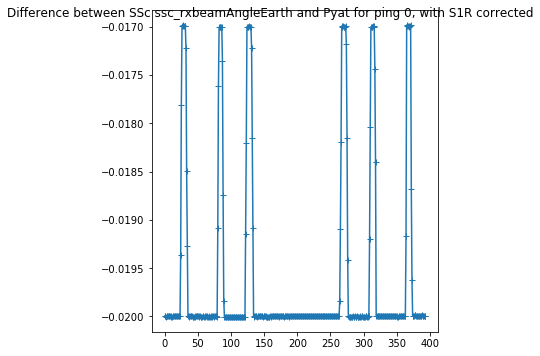

In [28]:
scope.display_signal(diff_Pyat_SSc-(-0.170),"Difference between SSc ssc_rxbeamAngleEarth and Pyat for ping 0, with S1R corrected")

## Explanation (A confirmer) :
* Sonarscope prend SR1 comme paramètre d'installation pour le transducteur RX, or il faudrait prendre SR2 dans le cas tu 2040 mono, cela implique un décalage de (-0.06)-0.11=-0.170
* Par ailleurs : l'interpolation de la navigation a un résultat inattendu : le premier faisceau du premier ping est daté à 18:31:19.898, la navigation associée dans le datagram viewer donne un roulis en plateau à -0.57 deg à ce moment (et 10ms avant et 10ms après). L'interpolation via la méthode my_interp1.m donne pour cette detection la valeur -0.55. (La valeur en python est bien à 0.57)

=> We consider python code to be validated 

# TODO
rajouter en python un filtrage de bessel pour lisser la navigation et ses valeurs par paliers

In [18]:
roll =  single_file.get_as_array(RootGrp.SonarGrp.BeamGroup1Grp.PLATFORM_ROLL)

scope.display_matrix(roll.reshape(-1,1),"roll")

Mean :  -0.49964687
Max :  0.3
Min :  -1.3
Median :  -0.5
Std :  0.23073393
                                                roll                                                


In [29]:
incidence_computer = IncidenceAngleComputer(files, directories.output_dir)

detection_depth=single_file.get_as_detection_masked_array(XConstants.RootGrp.SonarGrp.BeamGroup1Grp.BathymetryGrp.DETECTION_Z)
#detection_y=single_file.get_as_detection_masked_array(XConstants.RootGrp.SonarGrp.BeamGroup1Grp.BathymetryGrp.DETECTION_Y)
#detection_x=single_file.get_as_detection_masked_array(XConstants.RootGrp.SonarGrp.BeamGroup1Grp.BathymetryGrp.DETECTION_X)
#offset_x = single_file.get_as_array(XConstants.RootGrp.PlatformGrp.TRANSDUCER_OFFSET_X)
#offset_y = single_file.get_as_array(XConstants.RootGrp.PlatformGrp.TRANSDUCER_OFFSET_Y)
offset_z = single_file.get_as_array(XConstants.RootGrp.PlatformGrp.TRANSDUCER_OFFSET_Z)
detection_z = detection_depth
heave = single_file.get_as_array(XConstants.RootGrp.SonarGrp.BeamGroup1Grp.PLATFORM_VERTICAL_OFFSET)
heave = heave.reshape(-1,1)
detection_z = detection_depth - heave
#detection_z=detection_depth - offset_z[0]
#detection_y=detection_y-offset_y[0]
#detection_x=detection_x-offset_x[0]
# we evaluate the distance from water line to depth
# Tide should be taken in to account
# Same thing
scope.display_matrix(detection_z,"detection_z" , show=show_figure_immediately,)



Mean :  90.19122
Max :  93.97212
Min :  82.896515
Median :  90.20398712158203
Std :  0.84727347
                                            detection_z                                             


In [49]:
ssc_bathy= ssc.get_values(ssc.SSCPingBeamVariable.bathy)
scope.display_matrix(ssc_bathy, "Bathy from Sonarscope", True)


Mean :  -90.19108323270919
Max :  -82.95063781738281
Min :  -94.05574035644531
Median :  -90.19636917114258
Std :  0.8508683158574583
                                       Bathy from Sonarscope                                        


Mean :  0.03337938249920493
Max :  0.2140350341796875
Min :  0.0
Median :  nan
Std :  0.02901750361667997
                                     Diff between bathymetries                                      


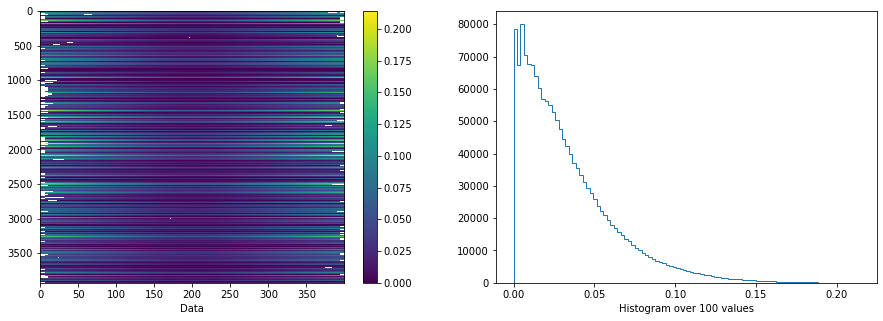

In [50]:
scope.display_matrix(np.abs(ssc_bathy--detection_z), "Diff between bathymetries",show=show_figure_immediately,bins=100)

Mean :  0.90465504
Max :  1.6213546
Min :  0.29865932
Median :  0.91008663
Std :  0.19607215
                                             immersion                                              
Mean :  1512.8002
Max :  1512.8
Min :  1512.8
Median :  1512.8
Std :  0.00012207031
                                          surface_celerity                                          


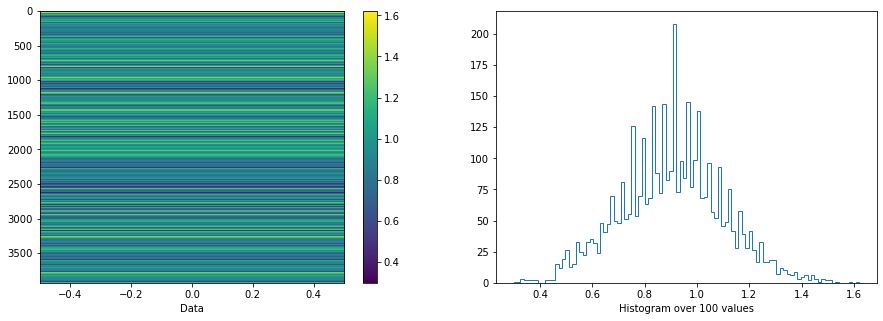

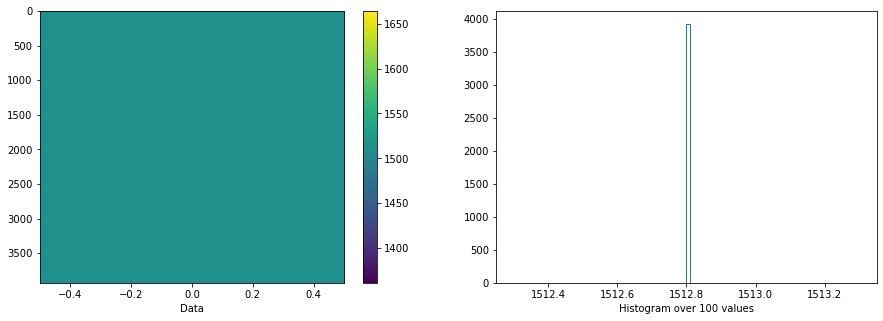

In [51]:
computed_iba_degrees = incidence_computer.compute_IBA(single_file,-ssc_bathy)


# DIFFERENCE 

Which depth shall be used to compare with sonarscope

Mean :  0.7026413825071991
Max :  1.5010393995967064
Min :  0.0
Median :  0.7137194835722269
Std :  0.40154929448918764
                                       computed IBA (degrees)                                       


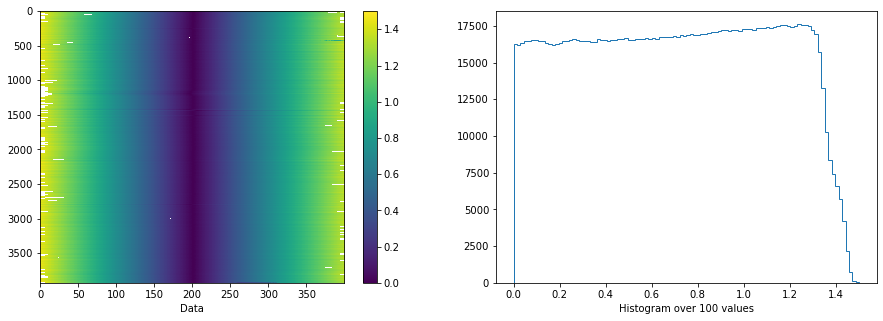

In [52]:
scope.display_matrix(computed_iba_degrees,"computed IBA (degrees)" , show=show_figure_immediately,)

In [53]:
#If we want to compare with IBA retrieved from file
#read_iba = single_file.get_as_detection_masked_array(
#                XConstants.RootGrp.SonarGrp.BeamGroup1Grp.BathymetryGrp.VendorSpecificGrp.GROUP_PATH+"beam_incidence_angle_adjustment")

#scope.display_matrix(read_iba,"IBA retrieved from file", show=show_figure_immediately,)

Mean :  0.7261668494541145
Max :  1.45794677734375
Min :  7.873401045799255e-05
Median :  0.7319259643554688
Std :  0.41411744614638846
                                        IBA from Sonarscope                                         


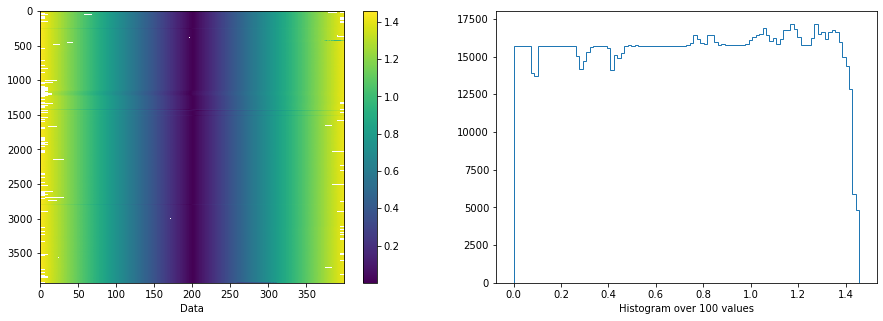

In [54]:
#angle sonarscope
import numpy as np

ssc_values= ssc.get_values(ssc.SSCPingBeamVariable.ssc_iba_earth)
scope.display_matrix(np.abs(ssc_values), "IBA from Sonarscope", True)

# 3rd DIFFERENCE 

Differences between ssc and python

Mean :  0.023525466946915208
Max :  0.13114731026774962
Min :  -0.05137051531936265
Median :  nan
Std :  0.022943015152893317
                            Final IBA Difference between ssc dans python                            


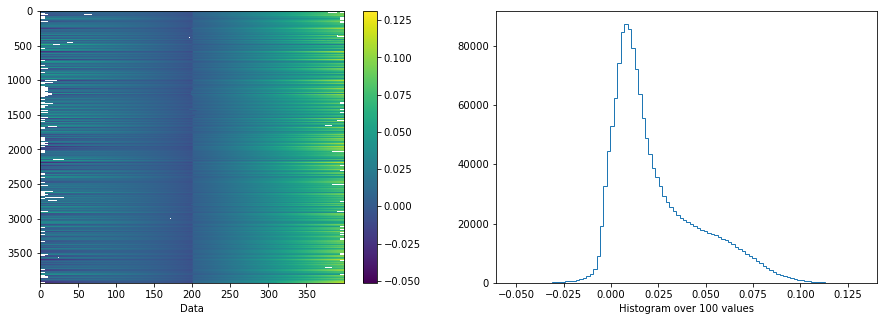

In [55]:
scope.display_matrix(np.abs(ssc_values)-computed_iba_degrees,"Final IBA Difference between ssc dans python", show=show_figure_immediately)